## Aplicación usando LangGraph

In [1]:
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env", override=True)
# Cargar las siguientes variables de entorno:
# LANGSMITH_TRACING=true
# LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
# LANGSMITH_PROJECT="eli5-bot"
# LANGSMITH_API_KEY="<redacted>"

# OPENAI_API_KEY="<redacted>"
# TAVILY_API_KEY="<redacted>"

True

Configuremos una herramienta llamada Tavily para permitir que nuestro asistente busque en la web al responder.

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(max_results=1)

C:\Users\sergi\AppData\Local\Temp\ipykernel_6948\632376592.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(max_results=1)


Diseñemos un prompt para RAG que usaremos a lo largo de todo el cuaderno.

In [3]:
prompt = """Sos un profesor y un experto en explicar temas complejos de una manera fácil de entender.
Tu trabajo es responder la pregunta dada de forma tal que incluso un niño de 5 años pueda comprenderla.
Se te ha proporcionado el contexto necesario para responder la pregunta.

Pregunta: {question} 

Contexto: {context}

Respuesta:"""
print("Prompt Template: ", prompt)

Prompt Template:  Sos un profesor y un experto en explicar temas complejos de una manera fácil de entender.
Tu trabajo es responder la pregunta dada de forma tal que incluso un niño de 5 años pueda comprenderla.
Se te ha proporcionado el contexto necesario para responder la pregunta.

Pregunta: {question} 

Contexto: {context}

Respuesta:


Definamos el estado para nuestro grafo. Vamos a llevar registro de la pregunta del usuario, la generación de nuestra aplicación y la lista de documentos relevantes.

In [4]:
from langchain_core.documents import Document
from typing import List
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

class GraphState(TypedDict):
    """
    Representa el estado de nuestro grafo.

    """
    question: str
    documents: List[str]
    messages: List[str]


Ahora definamos los nodos de nuestro grafo. Agregamos uno adicional para verificación 

In [5]:
from langchain_core.messages import HumanMessage

def search(state):
    """
    Búsqueda web basada en la pregunta reformulada

    Args:
        state (dict): El estado actual del grafo

    Returns:
        state (dict): Actualiza la clave documents con los resultados web agregados.
    """
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    web_docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in web_docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}
    
def explain(state: GraphState):
    """
    Generar respuesta
    Args:
        state (dict): El estado actual del grafo
    Returns:
        state (dict): Nueva clave agregada al estado, generation, que contiene la generación del LLM
    """
    question = state["question"]
    documents = state.get("documents", [])
    formatted = prompt.format(question=question, context="\n".join([d.page_content for d in documents]))
    generation = llm.invoke([HumanMessage(content=formatted)])
    return {"question": question, "messages": [generation]}


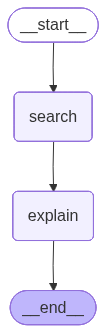

In [6]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

graph = StateGraph(GraphState)
graph.add_node("explain", explain)
graph.add_node("search", search)
graph.add_edge(START, "search")
graph.add_edge("search", "explain")
graph.add_edge("explain", END)


app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

## Testeando Nuestro Grafo


“Creemos una función auxiliar para mostrar nuestros resultados de forma prolija

In [7]:
def ask(question: str):
    for output in app.stream({"question": question}, stream_mode="updates"):
        if END in output or START in output:
            continue
        # Print any node outputs
        for key, value in output.items():
            if "messages" in value:
                print(value["messages"][0].content)

Finalmente, probemos nuestro chatbot y veamos cómo funciona

In [8]:
question = "Qué es la termodinámica?"
ask(question)

La termodinámica es como un juego que estudia cómo la energía se transforma en movimiento. Es como cuando usas una máquina para hacer algo, como un tren que se mueve gracias al calor. ¡Es muy interesante!
